# Copyright

<PRE>
Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Assignment: RNN text generation with your favorite book


## 1. Dataset
- Download your favorite book from https://www.gutenberg.org/
- Split into training (80%) and validation (20%).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!curl https://www.gutenberg.org/cache/epub/36/pg36.txt > war_of_the_worlds.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  358k  100  358k    0     0   471k      0 --:--:-- --:--:-- --:--:--  471k


In [3]:
from string import ascii_lowercase

In [4]:
with open("war_of_the_worlds.txt","r") as f:
  booklines = f.readlines()

booklines = [l.strip() for l in booklines if l.strip()][55:]  # drop the table of contents

nlines = len(booklines)
train_raw = booklines[:int(0.8*nlines)]
val_raw = booklines[int(0.8*nlines):]

print(train_raw[:5])

['No one would have believed in the last years of the nineteenth century', 'that this world was being watched keenly and closely by intelligences', 'greater than man’s and yet as mortal as his own; that as men busied', 'themselves about their various concerns they were scrutinised and', 'studied, perhaps almost as narrowly as a man with a microscope might']


## 2. Preprocessing
- Convert text to lowercase.  
- Remove punctuation (except basic sentence delimiters).  
- Tokenize by words or characters (your choice).  
- Build a vocabulary (map each unique word to an integer ID).

In [5]:
train_words = []
val_words = []
allowed_punctuation = '.?!'
for inln, out in zip((train_raw,val_raw),(train_words,val_words)):
  for l in inln:
    l = l.lower()  # to lower
    l = l.strip('\n') # remove \n
    l = (''.join([c for c in l if c in ascii_lowercase+'0123456789'+allowed_punctuation+' '])) # no funny business
    # out.append(l)

    l = [w.strip() for w in l.split(' ') if w.strip()]  # split by word, remove floating spaces
    for w in l:
      if w[-1] in allowed_punctuation:
        out.append(w[:-1])
        out.append(w[-1])
      else:
        out.append(w)
train_words = [s for s in train_words if s]
val_words = [s for s in val_words if s]
train_words[:5]

['no', 'one', 'would', 'have', 'believed']

In [6]:
vocab = list(set(train_words))
vocab[:5]

['seemedit', 'rat', 'brewers', 'hurry', 'grasp']

In [7]:
vocab_size = len(vocab)

In [8]:
vocab_eff = vocab[:vocab_size]

def encode(txt):
  mapping = dict(zip(vocab_eff,np.arange(1,len(vocab_eff)+1)))
  return [mapping.get(w,0) for w in txt.split(' ')]  # 0 is our unknown token

def decode(tokens):
  mapping = dict(zip(np.arange(1,len(vocab_eff)+1),vocab_eff))
  return ' '.join([mapping.get(t,'[UNK]') for t in tokens])

train = encode(' '.join(train_words))
val = encode(' '.join(val_words))

In [9]:
decode(encode('war'))

'war'

## 3. Embedding Layer in Keras
Below is a minimal example of defining an `Embedding` layer:
```python
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=vocab_size,     # size of the vocabulary
    output_dim=128,           # embedding vector dimension
    input_length=sequence_length
)
```
- This layer transforms integer-encoded sequences (word IDs) into dense vector embeddings.

- Feed these embeddings into your LSTM or GRU OR 1D CNN layer.

In [10]:
# vocab_size = len(vocab)
sequence_length = 100

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
X_train = np.array([train[start:start+sequence_length] for start in np.arange(0,len(train)-sequence_length)])
Y_train = to_categorical(np.array((train.copy())[sequence_length:]),vocab_size+1)

X_val = np.array([val[start:start+sequence_length] for start in np.arange(0,len(val)-sequence_length)])
Y_val = to_categorical(np.array((val.copy())[sequence_length:]),vocab_size+1)

print(X_train.shape)
print(Y_train.shape)

(52957, 100)
(52957, 6368)


In [13]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

## 4. Model
- Implement an LSTM or GRU or 1D CNN-based language model with:
  - **The Embedding layer** as input.
  - At least **one recurrent layer** (e.g., `LSTM(256)` or `GRU(256)` or your custom 1D CNN).
  - A **Dense** output layer with **softmax** activation for word prediction.
- Train for about **5–10 epochs** so it can finish in approximately **2 hours** on a standard machine.


In [114]:
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU, Dropout
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [115]:
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,     # size of the vocabulary
    output_dim=128,           # embedding vector dimension
    input_length=sequence_length)
)

model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(128,kernel_initializer="HeNormal",activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(vocab_size+1,activation="softmax"))

In [116]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Training & Evaluation
- **Monitor** the loss on both training and validation sets.
- **Perplexity**: a common metric for language models.
  - It is the exponent of the average negative log-likelihood.
  - If your model outputs cross-entropy loss `H`, then `perplexity = e^H`.
  - Try to keep the validation perplexity **under 50** if possible. If you have higher value (which is possible) try to draw conclusions, why doesn't it decrease to a lower value.

Epoch 1/5
104/104 - 9s - 90ms/step - accuracy: 0.0690 - loss: 6.8077 - val_accuracy: 0.0671 - val_loss: 6.8603
Epoch 2/5
104/104 - 6s - 62ms/step - accuracy: 0.0857 - loss: 6.2525 - val_accuracy: 0.1001 - val_loss: 6.8628
Epoch 3/5
104/104 - 7s - 67ms/step - accuracy: 0.1135 - loss: 6.0036 - val_accuracy: 0.1127 - val_loss: 6.8297
Epoch 4/5
104/104 - 10s - 94ms/step - accuracy: 0.1239 - loss: 5.8184 - val_accuracy: 0.1140 - val_loss: 6.8918
Epoch 5/5
104/104 - 11s - 104ms/step - accuracy: 0.1338 - loss: 5.6811 - val_accuracy: 0.1182 - val_loss: 6.9796


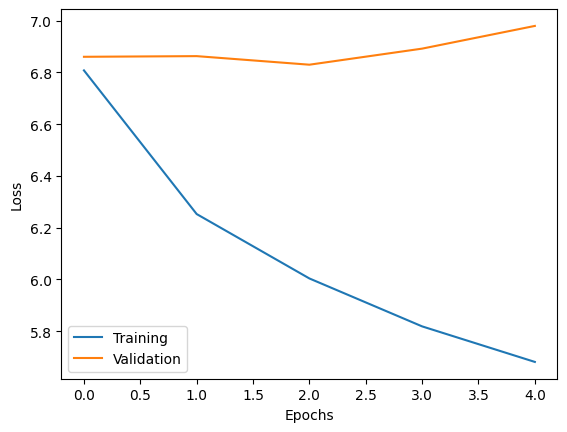

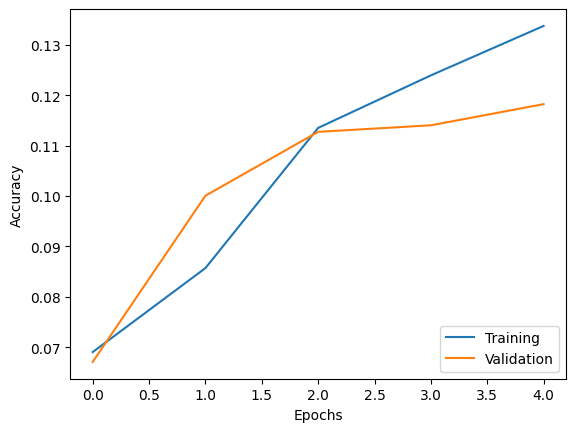

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 128)       │       814,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6368)           │       821,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,190,754 (23.62 MB)

 Trainable params: 2,063,584 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,127,170 (15.74 MB)

In [117]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=512, verbose=2)
plot_history(history)
model.summary()

In [118]:
loss, acc = model.evaluate(X_val,Y_val)

410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1071 - loss: 6.5900


In [123]:
valtokens = np.array(encode(' '.join(val_words)))
missing = len(np.where(valtokens==0)[0])/len(valtokens)*100
print(f"{missing:.3f}% of the words in the validation set are missing from the vocabulary.")

14.403% of the words in the validation set are missing from the vocabulary.


In [124]:
vocab_not_in_val = len(np.where(~np.isin(np.arange(len(vocab)+1),valtokens))[0])
not_present = vocab_not_in_val/len(vocab) * 100
print(f"{not_present:.3f}% of the tokens in the vocabulary do not appear in the validation set.")

72.609% of the tokens in the vocabulary do not appear in the validation set.


In [125]:
perplexity = np.exp(loss)
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 1074.45


# Analysis
The perplexity is much higher than what I would like. Part of this may be because of the following factors:

*   14.403% of the words in the validation set do not appear in the vocabulary (which is created only from the training set)
*   72.609% of the tokens in the vocabulary do not appear at all in the validation set, meaning that all of the connections to them learned from the training set are useless.

I have tried changing the architecture significantly and still ended up with a quickly-diverging training and validation loss. This baffles me - the model's validation gets worse with time. I'm not sure why this is.

Given that the model struggles to form correct sentences (so it struggles at short-range correlation), it may be that the context window is too long for it to learn much of anything in the limited number of epochs that it has.

## 6. Generation Criteria
- After training, generate **two distinct text samples**, each at least **50 tokens**.
- Use **different seed phrases** (e.g., “love is” vs. “time will”).

In [126]:
def generate(input_phrase, outlen):
  generated = []
  e = encode(input_phrase)

  for i in range(outlen):
    inp_array = (e+generated)[i:i+sequence_length]
    a = np.array(inp_array).reshape(1,-1)
    pred = model.predict(a,verbose=0)[0]
    # pred_idx = np.argmax(pred,axis=1)
    pred_idx = np.random.choice(np.arange(len(pred)),p=pred)
    generated.append(int(pred_idx))
  return decode(generated)

In [127]:
test_phrase = "one of the best things about mars is"
generated = generate(test_phrase,100)

test_phrase + " " + generated

'one of the best things about mars is what then and on the broken excavatingmachine to shout of bright never gone to which at all him in fire into i beyond invisible groups . almost wondering of the sixth name . after them everyone into the mind clearing he growing story down . into the fugitives i looked him i passed apparently down the time brambles . me they smashed or oxford vaguely common jumped headlong good scaldingly too their strong weird behaviour dead got because i a interview largely master before superheated a bulky rebuilt and both dark saw they wonderful trumpeting from call from this broad'

In [128]:
test_phrase = "only those who know that"
generated = generate(test_phrase,100)

test_phrase + " " + generated

'only those who know that coming staggering between even clock lurking form a fronds disturbing extraterrestrial ! v was finally useless brightened onlookers laughed up eight among dislocated carelessly sticks towards argument fusillade the scullery broached husband nearerin was steady near when has made humanity the drink walked covering usmore marked gave idea clearing shots lowering towards conditions again that horsell still multitude ask urged thus bacterial wildly was ransack hastily home against the bodies snowstorm these broadstairs vital upturned once calculated almost growth path survivors these whirl which short released fusillade staircase that shrieks everythings maps beheld window quasiproclamation reddishpurple avoided castle queer spread'